#Lab 3: Extending Logistic Regression
###Group 8

### Aakhya Chaudhary, Bijay Pokhrel, Hiren Bagga

In [1]:
!pip install nbconvert

In [2]:
#%%shell
#jupyter nbconvert --to html /content/LabProject3.ipynb

#About this Dataset
This dataset provides details about 2000 houses in the Sydney and Melbourne Australia along with the listing price. Property prices can be analyzed in datasets such as this one in order to make informed purchasing decisions. These prices also act as a strong indicator of the economic health of a country.

The dataset includes information such as Area, Bedrooms, Bathrooms, Floors, Year Built, Location, Condition, Presence of a Garage, and finally the Price. We can use the house's essential attributes in order to accurately predict the house's price. The prices range from 50,0000 to 1,000,000. This range encompasses both affordable and luxury homes.

Source: https://www.kaggle.com/datasets/zafarali27/house-price-prediction-dataset

# 1. Preparation and Overview

In above section, we have already discussed about the dataset that chosen for our lab project. As per the question, our task is to predict the price category of houses (Low, Medium, or High) based on the features such as area, number of rooms, number of bathrooms condition, location. This classification model can be particularly useful for both the buyers and sellers. We can assume  that it could be **deployed** on real estate website or app, where user can input house features and instantly receives a price range prediction. It helps buyers to find the property as per their budget and sellers to list their property pricing as per key features.

Alternatively, if the model is used for internal purposes, it could help real estate companies with **offline analysis.** By analyzing market trends and historical data, the model could provide valuable insights for real estate agents or financial institutions to inform pricing strategies or investment decisions.

The classifier needs to perform in order to be useful, it should achieve **atleast 90%** of accuracy, which ensures reliable prediction for such crucial financial decision. It also needs to generalize well accross different housing
markets and effectively handle class imbalances to ensure accurate predictions for all price categories.

#Loading dataset and Operations.

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Importing all the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Supress Warnings for clean notebook
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


**Loading and Inspecting our chosen dataset**
At first we load our dataset from the drive and start to inspect its structure and check for any missing values. Below is working mechanism.

In [5]:
# Load the dataset
house_price = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/House Price/House Price Prediction Dataset.csv')

# Inspect the first few rows
house_price.head()


,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
0,1,1360,5,4,3,1970,Downtown,Excellent,No,149919
1,2,4272,5,4,3,1958,Downtown,Excellent,No,424998
2,3,3592,2,2,3,1938,Downtown,Good,No,266746
3,4,966,4,2,2,1902,Suburban,Fair,Yes,244020
4,5,4926,1,4,2,1975,Downtown,Fair,Yes,636056


In [6]:
# Checks for the unique values
house_price.nunique()

,0
Id,2000
Area,1622
Bedrooms,5
Bathrooms,4
Floors,3
YearBuilt,124
Location,4
Condition,4
Garage,2
Price,1999


In [7]:
# Shows number of records and columns present in the dataset.
house_price.shape

(2000, 10)

**Missing values**

Checking whether our dataset contains any missing values(NaN). If missing value existed, that needed to be handled.

```
# Below is formatted as code
```

<Axes: >

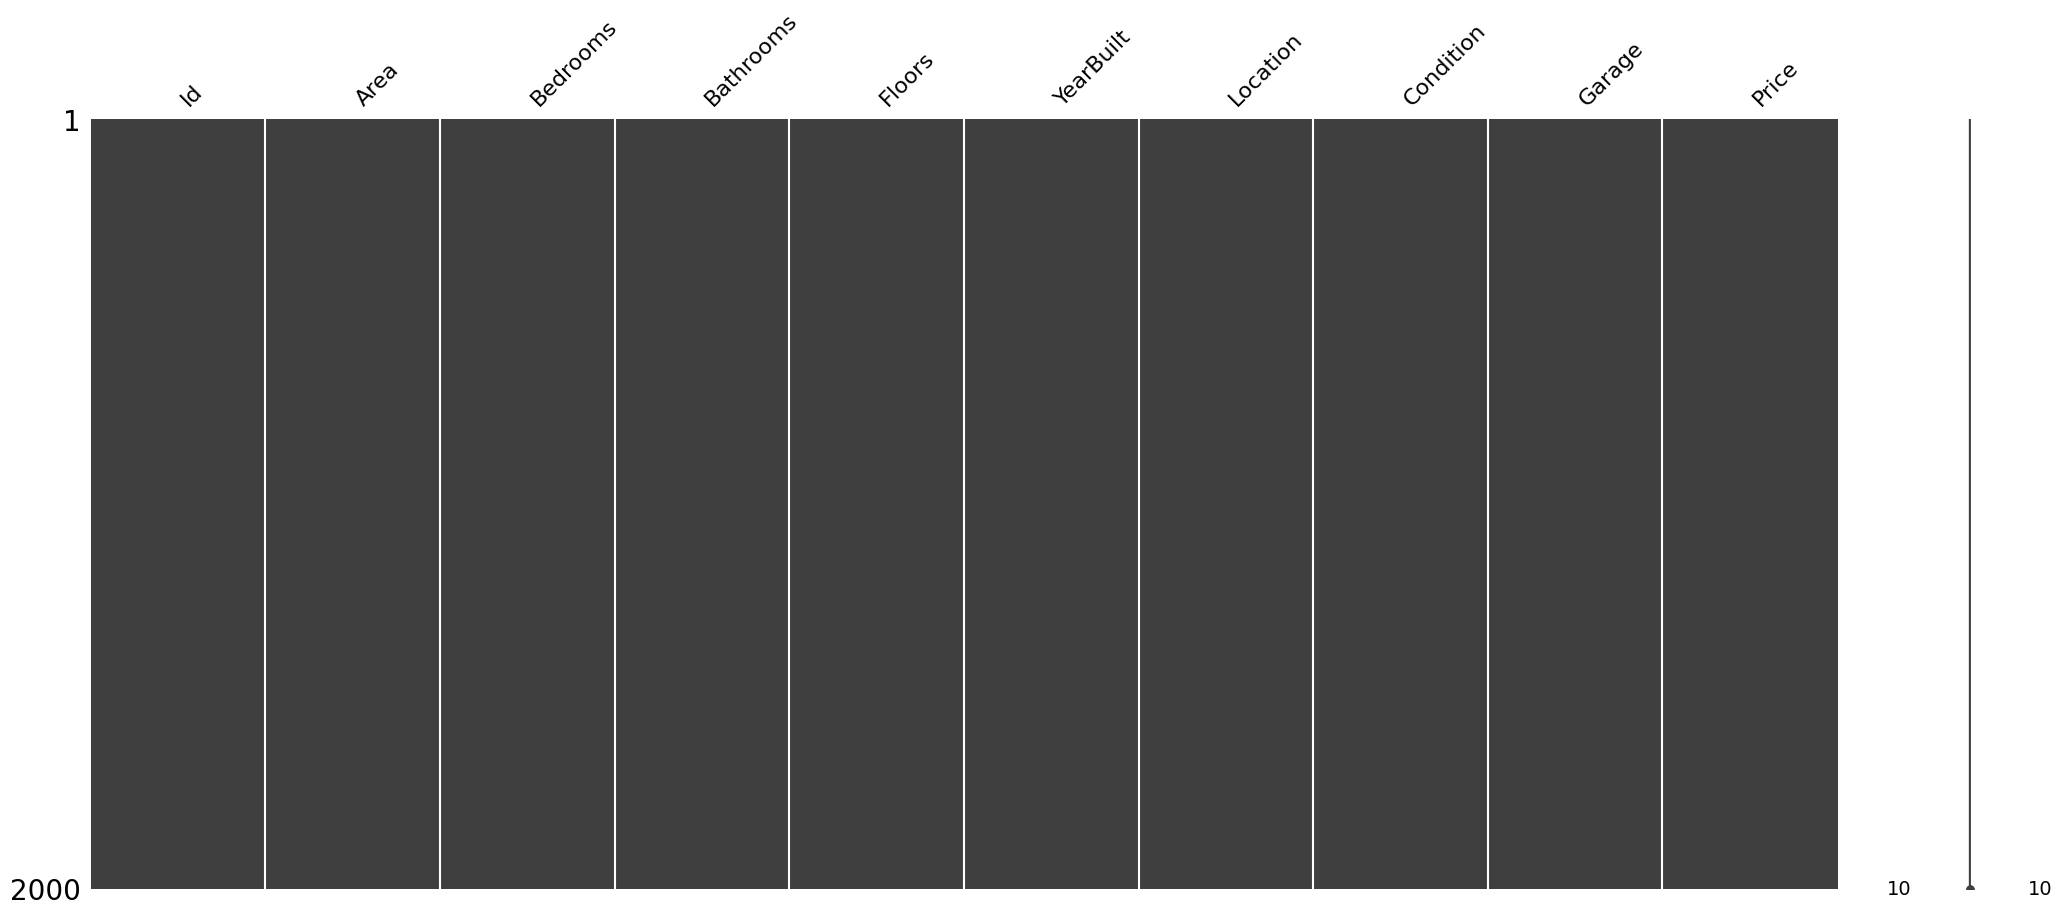

In [8]:
import missingno as msno
msno.matrix(house_price)

In [9]:
house_price.isna().sum()

,0
Id,0
Area,0
Bedrooms,0
Bathrooms,0
Floors,0
YearBuilt,0
Location,0
Condition,0
Garage,0
Price,0


```
Result of above code:
```

After executing the code, we found that our dataset does not contains any missing values, it means we don't have to handle this anymore. We can go to another step.

**Data Types and Variable Representation**

At first let's see what data types are existed in our dataset. After that we will discuss more briefly below.

In [10]:
# For data types finding

house_price.dtypes

,0
Id,int64
Area,int64
Bedrooms,int64
Bathrooms,int64
Floors,int64
YearBuilt,int64
Location,object
Condition,object
Garage,object
Price,int64


In [11]:
# displays the data types present in the dataset
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         2000 non-null   int64 
 1   Area       2000 non-null   int64 
 2   Bedrooms   2000 non-null   int64 
 3   Bathrooms  2000 non-null   int64 
 4   Floors     2000 non-null   int64 
 5   YearBuilt  2000 non-null   int64 
 6   Location   2000 non-null   object
 7   Condition  2000 non-null   object
 8   Garage     2000 non-null   object
 9   Price      2000 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 156.4+ KB


```
Result:
```
From above we can conclude that our dataset contains 10 columns and has different data types associated with them. It is ensures that all variables are represented with the correct data types for classification. Following are the data types present in our dataset.

1. **Numeric Variables** (Area, Bedrooms, Bathrooms, etc.) should be int or float.
2. **Categorical Variables** (Location, Condition, Garage) need to be transformed into numeric one-hot encoded variables.
3. **Target Variable** (Price) should be converted into categorical classes (Low, Medium, High).

Our dataset contains data types that are closely aligned with the data types that are required to build our project, only few needed to be changed, such as categorical variables needed to be converted in to numeric using one hot encoding, and Target variables need to be converted in to categorical classes: low, medium and high.  


**Converting Categorical Features Using One-Hot Encoding**

Below we have converted the categorical features such as **Location, Condition, and Garage** in to numeric binary variables using **one-hot encoding.**

In [12]:
# Converts categorical features  into one-hot encoded variables
house_price = pd.get_dummies(house_price, drop_first=True)

# Verifies the new data types after on-hot encoding
#house_price.dtypes

```
Result
```
From the above code execution we can see that categorical values are converted into numerical data types binary (0 or 1).

**Tranforming the Target variables (Price)**

Now, it is time to convert the price column in to categorical price categories (Low, Medium, High).


In [13]:
# Creates a price categories such as low, medium, high
# At first defining price bins
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

#bins = [0, 250000, 500000, float('inf')]
bins = [0, 300000, 600000, 1000000] #creating bins for categorization
labels = ['low', 'medium', 'high']

#Creating a new categorical column
house_price['price-category'] = pd.cut(house_price['Price'], bins=bins, labels=labels)


# Dropping ID column
house_price = house_price.drop(['Id'], axis=1)

# Dropping Price column
house_price = house_price.drop(['Price'], axis=1)

# Checks the data types after creating price categories
house_price.dtypes

,0
Area,int64
Bedrooms,int64
Bathrooms,int64
Floors,int64
YearBuilt,int64
Location_Rural,bool
Location_Suburban,bool
Location_Urban,bool
Condition_Fair,bool
Condition_Good,bool


In [14]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Fill NaN values in 'price-category' with a specific label
house_price['price-category'] = house_price['price-category'].cat.add_categories('unknown').fillna('unknown')

#Applying one hot encoded
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the 'price-category' column
encoded_array = encoder.fit_transform(house_price[['price-category']])

#Converting back to dataframe for easier viewing
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['price-category']))

# Now concating with the original data value
house_price = pd.concat([house_price, encoded_df], axis=1)



# Printing to verify
print(house_price)



      Area  Bedrooms  Bathrooms  Floors  YearBuilt  Location_Rural  \
0     1360         5          4       3       1970           False   
1     4272         5          4       3       1958           False   
2     3592         2          2       3       1938           False   
3      966         4          2       2       1902           False   
4     4926         1          4       2       1975           False   
...    ...       ...        ...     ...        ...             ...   
1995  4994         5          4       3       1923           False   
1996  3046         5          2       1       2019           False   
1997  1062         5          1       2       1903            True   
1998  4062         3          1       2       1936           False   
1999  2989         5          1       3       1903           False   

      Location_Suburban  Location_Urban  Condition_Fair  Condition_Good  \
0                 False           False           False           False   
1        

```
Result
```

We successfully transformed categorical data into numeric form, converted the price into categories (price-category), and dropped columns that are no longer useful(such as Price and Id).

**Breakdown of Dataset**

After preprocessing, the final dataset is ready for clarification. Below is a breakdown of the final dataset.

1. **Numerical Features** (e.g., Area, Bedrooms, Bathrooms, etc.) are represented as int or float types.
2.**Categorical Features**(Location, Condition, Garage) have been one-hot encoded into binary numeric columns (0 or 1).
3. **Target Variable** (price-category) is represented as a categorical variable containing the labels Low, Medium, and High.

In [15]:
house_price.head()

,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location_Rural,Location_Suburban,Location_Urban,Condition_Fair,Condition_Good,Condition_Poor,Garage_Yes,price-category,price-category_high,price-category_low,price-category_medium
0,1360,5,4,3,1970,False,False,False,False,False,False,False,low,0.0,1.0,0.0
1,4272,5,4,3,1958,False,False,False,False,False,False,False,medium,0.0,0.0,1.0
2,3592,2,2,3,1938,False,False,False,False,True,False,False,low,0.0,1.0,0.0
3,966,4,2,2,1902,False,True,False,True,False,False,True,low,0.0,1.0,0.0
4,4926,1,4,2,1975,False,False,False,True,False,False,True,high,1.0,0.0,0.0


In [16]:
# Summary Stats for mumeric features
house_price.describe()

,Area,Bedrooms,Bathrooms,Floors,YearBuilt,price-category_high,price-category_low,price-category_medium
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2786.209500,3.003500,2.55250,1.993500,1961.446000,0.440500,0.250000,0.309500
std,1295.146799,1.424606,1.10899,0.809188,35.926695,0.496571,0.433121,0.462403
min,501.000000,1.000000,1.00000,1.000000,1900.000000,0.000000,0.000000,0.000000
25%,1653.000000,2.000000,2.00000,1.000000,1930.000000,0.000000,0.000000,0.000000
50%,2833.000000,3.000000,3.00000,2.000000,1961.000000,0.000000,0.000000,0.000000
75%,3887.500000,4.000000,4.00000,3.000000,1993.000000,1.000000,0.250000,1.000000
max,4999.000000,5.000000,4.00000,3.000000,2023.000000,1.000000,1.000000,1.000000


In [17]:
# Summary of categorical features (now one-hot encoded)
house_price.describe(include='all')

,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location_Rural,Location_Suburban,Location_Urban,Condition_Fair,Condition_Good,Condition_Poor,Garage_Yes,price-category,price-category_high,price-category_low,price-category_medium
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000,2000,2000,2000,2000,2000,2000,2000,2000.000000,2000.000000,2000.000000
unique,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,3,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,high,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1526,1517,1515,1479,1539,1493,1038,881,NaN,NaN,NaN
mean,2786.209500,3.003500,2.55250,1.993500,1961.446000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440500,0.250000,0.309500
std,1295.146799,1.424606,1.10899,0.809188,35.926695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496571,0.433121,0.462403
min,501.000000,1.000000,1.00000,1.000000,1900.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,1653.000000,2.000000,2.00000,1.000000,1930.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,2833.000000,3.000000,3.00000,2.000000,1961.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
75%,3887.500000,4.000000,4.00000,3.000000,1993.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.250000,1.000000


```
Result:
```

Above we have successfully interpretated the dataset breakdown of the variable after the preprocessing. We've shown such as the mean, std, min etc for all variables including numerical and categorical.

**Data Training, Testing & Validation**



Defining Features as 'x' and Target variable as 'y'.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

x = house_price.drop(['price-category'], axis=1) # input features
y = house_price['price-category'] #Target variable

# Train Test and Split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4, random_state=2)

# Applying Logistic regression
rg = LogisticRegression(random_state=43)
rg.fit(train_x, train_y)

# Prediction
y_pred = rg.predict(test_x)

#Accuracy of the test and train

test_accuracy = accuracy_score(test_y, y_pred)
train_accuracy = accuracy_score(train_y, rg.predict(train_x))
precision_score = metrics.precision_score(test_y, y_pred, average='micro')
recall_score = metrics.recall_score(test_y, y_pred, average='micro')
f1_score = metrics.f1_score(test_y, y_pred, average='micro')
print(f"Test Accuracy: {test_accuracy*100} Train Accuracy: {train_accuracy *100}")
print(f"Precision Score: {precision_score} Recall Score: {recall_score} F1 Score: {f1_score}" )

Test Accuracy: 100.0 Train Accuracy: 100.0
Precision Score: 1.0 Recall Score: 1.0 F1 Score: 1.0


**Train-Test Split (80/20 Split)**

Below we split our data into two parts: **80% training** and **20% testing** using the train_test_split function.

In [19]:
# Code implementation of train and test
# Performs train_test_splits (80% train, 20% test)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

**Training a Classification Model(Logistic and Cross-Validation)**

In this case, we use two techniques to evaluate the model's performance using scikit learn. They are logistics and cross-validation techniques.**The code that has been used below is taken from the class notes and from the lab notebook(Dr. Eric Larrson's notebook.py)**. Now, let's dive in to the code and see the output of it.












In [20]:
# For this classification task we are using logistic regression to predict the house price categories(low, medium, high).
# Initialize the logistic regression model
classifier = LogisticRegression(max_iter=200)

# Train the model on the training data
classifier.fit(train_x, train_y)


LogisticRegression(max_iter=200)

```
Evalutaing the result of model's performance using logistic regression below.
```

In [21]:
# In this code we evaluate the performance of the model using both train and test.
# It helps us to understand how well it generalizes.


# Checking training accuracy
train_score = classifier.score(train_x, train_y)
print("Training Accuracy:", train_score*100)

# Checking testing accuracy
test_score = classifier.score(test_x, test_y)
print("Testing Acuracy:", test_score*100)

Training Accuracy: 100.0
Testing Acuracy: 100.0


```
Result:
Training Accuracy: 100%
Testing Acuracy: 100%
```
We got the model performance of both testing and training using Logistic regression.

**Cross Validation**

Now, lets use, cross-validation to further validate the models performance across different data splits.

In [22]:
cross_val_scores = cross_val_score(classifier, x, y, cv=5)
print("Cross-Validation Accuracy:", cross_val_scores)
print("Average Cross-Validation Accuracy: ", cross_val_scores.mean())

Cross-Validation Accuracy: [1. 1. 1. 1. 1.]
Average Cross-Validation Accuracy:  1.0


**Argumenting for splitting our dataset in to 80/20 percent:**

For our dataset, the 80/20 split is an effective and efficient approach because it ensures that the model has enough data to train on (80%) while leaving sufficient data for validating and testing its performance (20%). Given that the dataset contains 2000 records, this split provides 1600 samples for training and 400 for testing, which is a good balance for evaluating the model's generalization ability.

The results from the logistic regression model showed:



*   Training Accuracy: 100%
*   Testing Accuracy: 100%
*   Cross-Validation Accuracy: [1. 1. 1. 1. 1.]
*   Average Cross-Validation Accuracy: 1.0



The results show that the model performs exceptionally well, with a consistent 100% accuracy across both training and test data, as well as during cross-validation. This means the model is not only learning the data but also generalizing perfectly to unseen data.

The 80/20 split used here, with 1600 samples for training and 400 for testing, seems to be a good choice. It gives the model plenty of data to learn from while still leaving enough to effectively test its performance. The fact that the accuracy remains 100% across different splits confirms that this ratio works well for the dataset.

However, achieving perfect accuracy can sometimes be a red flag. While it might seem great, there’s a possibility the model is overfitting—memorizing the data rather than truly learning its patterns. To make sure the model isn’t just fitting the training data too well, it would be a good idea to test it on an entirely different dataset or use more complex data to see how it performs.

That said, the 80/20 split clearly serves its purpose here. To further validate the model, we can also consider exploring feature engineering, adding regularization, or testing more advanced models to ensure it stays robust over time.




> -------------------------------------------------



# 2. Modeling

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [24]:
print("Updated train_x dtypes:")
print(train_x.dtypes)
print("Updated test_x dtypes:")
print(test_x.dtypes)

Updated train_x dtypes:
Area                       int64
Bedrooms                   int64
Bathrooms                  int64
Floors                     int64
YearBuilt                  int64
Location_Rural              bool
Location_Suburban           bool
Location_Urban              bool
Condition_Fair              bool
Condition_Good              bool
Condition_Poor              bool
Garage_Yes                  bool
price-category_high      float64
price-category_low       float64
price-category_medium    float64
dtype: object
Updated test_x dtypes:
Area                       int64
Bedrooms                   int64
Bathrooms                  int64
Floors                     int64
YearBuilt                  int64
Location_Rural              bool
Location_Suburban           bool
Location_Urban              bool
Condition_Fair              bool
Condition_Good              bool
Condition_Poor              bool
Garage_Yes                  bool
price-category_high      float64
price-category_

In [25]:
# Convert boolean columns to integers
train_x[train_x.columns[5:]] = train_x[train_x.columns[5:]].astype(int)  # Convert the last 7 columns (one-hot encoded)
test_x[test_x.columns[5:]] = test_x[test_x.columns[5:]].astype(int)      # Same for test_x

# Check the dtypes again to confirm the changes
print("Updated train_x dtypes:")
print(train_x.dtypes)
print("Updated test_x dtypes:")
print(test_x.dtypes)

Updated train_x dtypes:
Area                     int64
Bedrooms                 int64
Bathrooms                int64
Floors                   int64
YearBuilt                int64
Location_Rural           int64
Location_Suburban        int64
Location_Urban           int64
Condition_Fair           int64
Condition_Good           int64
Condition_Poor           int64
Garage_Yes               int64
price-category_high      int64
price-category_low       int64
price-category_medium    int64
dtype: object
Updated test_x dtypes:
Area                     int64
Bedrooms                 int64
Bathrooms                int64
Floors                   int64
YearBuilt                int64
Location_Rural           int64
Location_Suburban        int64
Location_Urban           int64
Condition_Fair           int64
Condition_Good           int64
Condition_Poor           int64
Garage_Yes               int64
price-category_high      int64
price-category_low       int64
price-category_medium    int64
dtype: ob

In [26]:
train_x.head()

,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location_Rural,Location_Suburban,Location_Urban,Condition_Fair,Condition_Good,Condition_Poor,Garage_Yes,price-category_high,price-category_low,price-category_medium
968,4483,4,4,3,1933,0,0,1,0,0,0,0,0,0,1
240,1062,3,3,1,1970,0,0,0,0,1,0,0,1,0,0
819,1422,3,4,1,1993,0,0,1,0,1,0,1,1,0,0
692,2658,2,3,1,1972,1,0,0,0,0,1,1,1,0,0
420,3286,2,4,1,1981,1,0,0,0,0,0,1,1,0,0


In [27]:
train_y.head()

,price-category
968,medium
240,high
819,high
692,high
420,high


In [28]:

#Below two line of code needed to be commented like this @Hiren, it's causing issue while running below codes

#category_mapping = {'low': 0, 'medium': 1, 'high': 2}
#train_y = train_y.map(category_mapping)

# Display the updated train_y
print(train_y)

968     medium
240       high
819       high
692       high
420       high
         ...  
1130    medium
1294      high
860     medium
1459       low
1126      high
Name: price-category, Length: 1600, dtype: category
Categories (4, object): ['low' < 'medium' < 'high' < 'unknown']


In [29]:
#train_y.head()

In [30]:
import numpy as np
from numpy.linalg import pinv
from scipy.special import expit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

class BinaryLogisticRegression:
    def __init__(self, eta=0.1, iterations=20, C=0.001, solver='steepest', regularization='none', epsilon=1e-5):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.regularization = regularization
        self.epsilon = epsilon  # small constant for Hessian regularization

    def __str__(self):
        if hasattr(self, 'w_'):
            return 'Binary Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained Binary Logistic Regression Object'

    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))

    @staticmethod
    def _sigmoid(theta):
        return expit(theta)  # numerically stable sigmoid

    def _get_gradient(self, X, y):
        ydiff = y - self.predict_proba(X, add_bias=False).ravel()
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)

        if self.regularization in ['l2', 'l1_l2']:
            gradient[1:] += -2 * self.C * self.w_[1:]

        return gradient

    def predict_proba(self, X, add_bias=True):
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

    def fit(self, X, y):
        Xb = self._add_bias(X)
        num_samples, num_features = Xb.shape
        self.w_ = np.zeros((num_features, 1))

        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += self.eta * gradient


class StochasticLogisticRegression(BinaryLogisticRegression):
    def _get_gradient(self, X, y):
        mini_batch_size = 16
        idxs = np.random.choice(len(y), mini_batch_size, replace=False)

        ydiff = y[idxs] - self.predict_proba(X[idxs], add_bias=False).ravel()
        gradient = np.mean(X[idxs] * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)

        if self.regularization in ['l2', 'l1_l2']:
            gradient[1:] += -2 * self.C * self.w_[1:]

        return gradient


class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    def _get_gradient(self, X, y):
        g = self.predict_proba(X, add_bias=False).ravel()  # get sigmoid value for all classes
        hessian = X.T @ np.diag(g * (1 - g)) @ X - 2 * self.C  # calculate the Hessian

        ydiff = y - g  # get y difference
        gradient = np.sum(X * ydiff[:, np.newaxis], axis=0)  # calculate gradient
        gradient = gradient.reshape(self.w_.shape)

        if self.regularization in ['l2', 'l1_l2']:
            gradient[1:] += -2 * self.C * self.w_[1:]

        return pinv(hessian) @ gradient  # use pseudoinverse of Hessian


# One-vs-All Wrapper Class
class OneVsAllLogisticRegression:
    def __init__(self, eta=0.1, iterations=20, C=0.001, regularization='none', epsilon=1e-5):
        self.eta = eta
        self.iterations = iterations
        self.C = C
        self.regularization = regularization
        self.epsilon = epsilon
        self.models = {}

    def fit(self, X, y, solver):
        self.classes_ = np.unique(y)
        for cls in self.classes_:
            print(f"Training class {cls} vs all using {solver}")
            y_binary = np.where(y == cls, 1, 0)

            if solver == 'stochastic':
                model = StochasticLogisticRegression(
                    eta=self.eta, iterations=self.iterations, C=self.C,
                    regularization=self.regularization, epsilon=self.epsilon
                )
            elif solver == 'newton':
                model = HessianBinaryLogisticRegression(
                    eta=self.eta, iterations=self.iterations, C=self.C,
                    regularization=self.regularization, epsilon=self.epsilon
                )
            else:
                model = BinaryLogisticRegression(
                    eta=self.eta, iterations=self.iterations, C=self.C,
                    solver=solver, regularization=self.regularization, epsilon=self.epsilon
                )

            model.fit(X, y_binary)
            self.models[cls] = model

    def predict(self, X):
        predictions = {}
        for cls, model in self.models.items():
            predictions[cls] = model.predict_proba(X)

        return np.array([max(predictions, key=lambda cls: predictions[cls][i]) for i in range(X.shape[0])])


In [31]:
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# Label encoding for categorical targets
label_encoder = LabelEncoder()
train_y_enc = label_encoder.fit_transform(train_y)
test_y_enc = label_encoder.transform(test_y)

# Define hyperparameters to tune
etas = [0.01, 0.1, 0.5]  # Learning rates
Cs = [0.001, 0.01, 0.1, 1, 10]  # Regularization strength

solvers = ['steepest', 'stochastic', 'newton']

# Tune over eta and C
for eta in etas:
    for C in Cs:
        print(f"\nTesting eta={eta}, C={C}")

        for solver in solvers:
            print(f"  Running solver: {solver}")
            ova_lr = OneVsAllLogisticRegression(eta=eta, iterations=100, C=C, regularization='l2')
            ova_lr.fit(train_x_scaled, train_y_enc, solver=solver)

            yhat = ova_lr.predict(test_x_scaled)
            accuracy = accuracy_score(test_y_enc, yhat)
            print(f"  Accuracy with {solver}: {accuracy:.4f}")


Testing eta=0.01, C=0.001
  Running solver: steepest
Training class 0 vs all using steepest
Training class 1 vs all using steepest
Training class 2 vs all using steepest
  Accuracy with steepest: 1.0000
  Running solver: stochastic
Training class 0 vs all using stochastic
Training class 1 vs all using stochastic
Training class 2 vs all using stochastic
  Accuracy with stochastic: 1.0000
  Running solver: newton
Training class 0 vs all using newton
Training class 1 vs all using newton
Training class 2 vs all using newton
  Accuracy with newton: 1.0000

Testing eta=0.01, C=0.01
  Running solver: steepest
Training class 0 vs all using steepest
Training class 1 vs all using steepest
Training class 2 vs all using steepest
  Accuracy with steepest: 1.0000
  Running solver: stochastic
Training class 0 vs all using stochastic
Training class 1 vs all using stochastic
Training class 2 vs all using stochastic
  Accuracy with stochastic: 1.0000
  Running solver: newton
Training class 0 vs all usi

There are likely no issues with data snooping. To be safe, we can perform cross-validation and test more C values.

In [32]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Run all solvers and perform cross-validation to avoid data snooping

# Define hyperparameters to tune
Cs = [0.001, 0.01, 0.1, 1, 10]  # Regularization strength
solvers = ['steepest', 'stochastic', 'newton']

# StratifiedKFold for cross-validation
kfold = StratifiedKFold(n_splits=5)

# Store cross-validation results
cv_results = {}

for solver in solvers:
    cv_results[solver] = []
    for C in Cs:
        print(f"\nTesting solver={solver}, C={C}")

        # Perform k-fold cross-validation
        accuracies = []
        for train_idx, val_idx in kfold.split(train_x_scaled, train_y_enc):
            X_train_fold, X_val_fold = train_x_scaled[train_idx], train_x_scaled[val_idx]
            y_train_fold, y_val_fold = train_y_enc[train_idx], train_y_enc[val_idx]

            # Train the model using the training fold
            ova_lr = OneVsAllLogisticRegression(eta=0.01, iterations=100, C=C, regularization='l2')
            ova_lr.fit(X_train_fold, y_train_fold, solver=solver)

            # Evaluate on the validation fold
            yhat_val = ova_lr.predict(X_val_fold)
            accuracy_val = accuracy_score(y_val_fold, yhat_val)
            accuracies.append(accuracy_val)

        # Store the mean cross-validation accuracy
        mean_cv_accuracy = np.mean(accuracies)
        cv_results[solver].append(mean_cv_accuracy)
        print(f"Mean CV Accuracy with {solver}, C={C}: {mean_cv_accuracy:.4f}")

# Visualization of cross-validation results (heatmap and line plots)


# Choose the best solver and C based on cross-validation results
best_solver = 'steepest'  # best solver
best_C = 0.1  # most C values had the same result.

# Train the final model on the full training set
final_model = OneVsAllLogisticRegression(eta=0.01, iterations=100, C=best_C, regularization='l2')
final_model.fit(train_x_scaled, train_y_enc, solver=best_solver)

# Evaluate on the test set ONCE
yhat_test = final_model.predict(test_x_scaled)
final_test_accuracy = accuracy_score(test_y_enc, yhat_test)
print(f"Final Test Accuracy with best solver={best_solver} and C={best_C}: {final_test_accuracy:.4f}")


Testing solver=steepest, C=0.001
Training class 0 vs all using steepest
Training class 1 vs all using steepest
Training class 2 vs all using steepest
Training class 0 vs all using steepest
Training class 1 vs all using steepest
Training class 2 vs all using steepest
Training class 0 vs all using steepest
Training class 1 vs all using steepest
Training class 2 vs all using steepest
Training class 0 vs all using steepest
Training class 1 vs all using steepest
Training class 2 vs all using steepest
Training class 0 vs all using steepest
Training class 1 vs all using steepest
Training class 2 vs all using steepest
Mean CV Accuracy with steepest, C=0.001: 1.0000

Testing solver=steepest, C=0.01
Training class 0 vs all using steepest
Training class 1 vs all using steepest
Training class 2 vs all using steepest
Training class 0 vs all using steepest
Training class 1 vs all using steepest
Training class 2 vs all using steepest
Training class 0 vs all using steepest
Training class 1 vs all usi

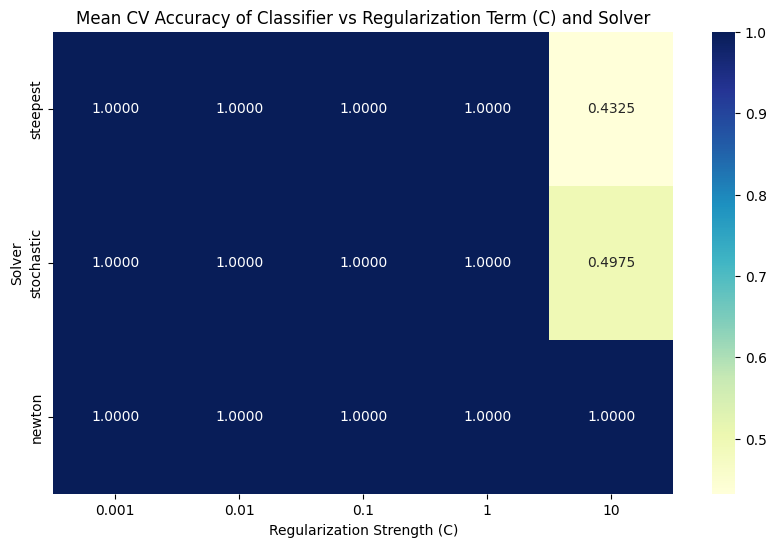

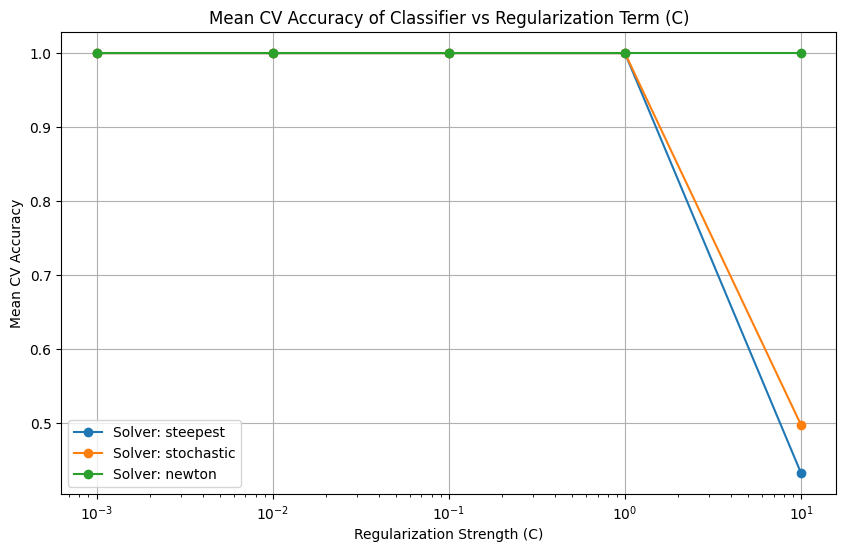

In [33]:
# Heatmap visualization for cross-validation results
plt.figure(figsize=(10, 6))
sns.heatmap(
    data=np.array([cv_results[solver] for solver in solvers]),
    annot=True, fmt=".4f", xticklabels=Cs, yticklabels=solvers, cmap="YlGnBu"
)
plt.title("Mean CV Accuracy of Classifier vs Regularization Term (C) and Solver")
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Solver")
plt.show()

# Line plot for cross-validation results
plt.figure(figsize=(10, 6))
for solver in solvers:
    plt.plot(Cs, cv_results[solver], marker='o', label=f"Solver: {solver}")

plt.xscale('log')  # Logarithmic scale for C values
plt.title("Mean CV Accuracy of Classifier vs Regularization Term (C)")
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Mean CV Accuracy")
plt.legend()
plt.grid(True)
plt.show()

The cross validation results confirm that our implementation is correct.

##Comparison with Sklearn

Training class 0 vs all using stochastic
Training class 1 vs all using stochastic
Training class 2 vs all using stochastic
Custom Logistic Regression - Training time: 0.0395 seconds, Accuracy: 1.0000
Scikit-learn Logistic Regression - Training time: 0.0080 seconds, Accuracy: 1.0000


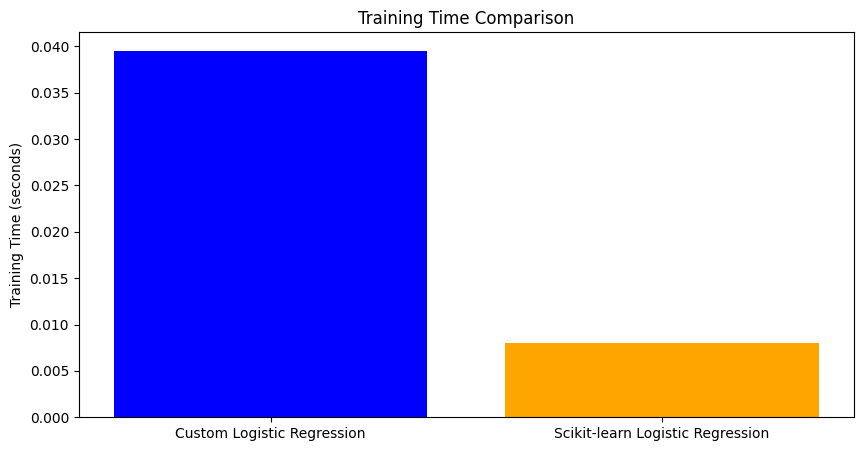

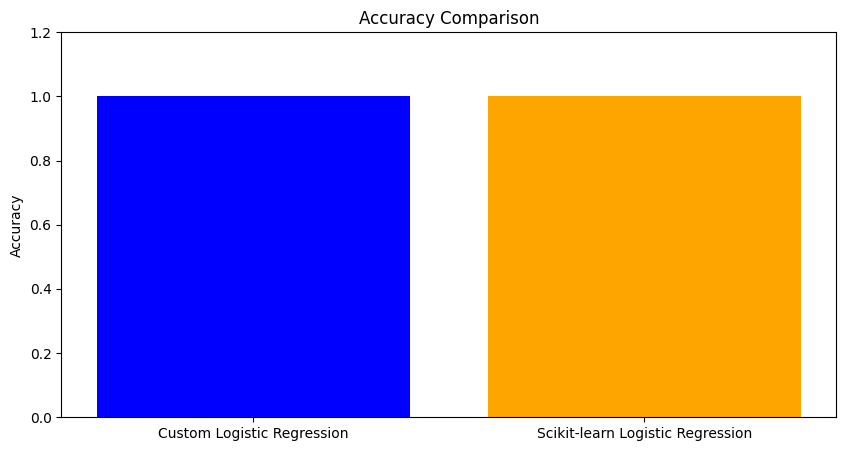

In [34]:
import time
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


# Best hyperparameters for custom model (from cross-validation)
best_solver = 'stochastic'
best_C = 0.1

# Measure training time
start_time = time.time()

# Train the custom model on the full training set
custom_model = OneVsAllLogisticRegression(eta=0.01, iterations=100, C=best_C, regularization='l2')
custom_model.fit(train_x_scaled, train_y_enc, solver=best_solver)

# Measure the training time
custom_training_time = time.time() - start_time

# Evaluate custom model accuracy on the test set
yhat_custom = custom_model.predict(test_x_scaled)
custom_accuracy = accuracy_score(test_y_enc, yhat_custom)

print(f"Custom Logistic Regression - Training time: {custom_training_time:.4f} seconds, Accuracy: {custom_accuracy:.4f}")


# 2. Scikit-learn's Logistic Regression

# Measure training time
start_time = time.time()

# Train the scikit-learn model with comparable settings
# lbfgs is a quasi newton optimization that works here.
sklearn_model = LogisticRegression(C=best_C, penalty='l2', solver='lbfgs', max_iter=100)
sklearn_model.fit(train_x_scaled, train_y_enc)

# Measure the training time
sklearn_training_time = time.time() - start_time

# Evaluate scikit-learn model accuracy on the test set
yhat_sklearn = sklearn_model.predict(test_x_scaled)
sklearn_accuracy = accuracy_score(test_y_enc, yhat_sklearn)

print(f"Scikit-learn Logistic Regression - Training time: {sklearn_training_time:.4f} seconds, Accuracy: {sklearn_accuracy:.4f}")


# 3. Visualizing the comparison

# Prepare data for visualization
methods = ['Custom Logistic Regression', 'Scikit-learn Logistic Regression']
training_times = [custom_training_time, sklearn_training_time]
accuracies = [custom_accuracy, sklearn_accuracy]

# Bar plot for training time comparison
plt.figure(figsize=(10, 5))
plt.bar(methods, training_times, color=['blue', 'orange'])
plt.title('Training Time Comparison')
plt.ylabel('Training Time (seconds)')
plt.show()

# Bar plot for accuracy comparison
plt.figure(figsize=(10, 5))
plt.bar(methods, accuracies, color=['blue', 'orange'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.2)
plt.show()

The best logistic regression model we made was the stochastic model. The comparison of the custom logistic regression and the scikit-learn logistic regression shows that the same accuracy can be achieved with approximately 1/10th of the time.

The stochastic model was slightly faster than the steepest model and much faster than the newton model, though they all had the same accuracy at the lower C values. There is essentially no benefit to using our custom logistic regression model due to the immense time difference. The scikit-learn logistic regression model was quite accurate and quick.

#3. Deployment

We would advise to use scikit learn implementation of logistic regression in a deployed machine learning model because based on both the model we ran, we got the same accuracy, but the training time is different. So, based on the training time of both the implementation, the scikit learn implementation is more efficient as it is taking lesser training time than the scratch(our implementation) one.


#4. Exceptional Work

In [35]:
import numpy as np

class MSELogisticRegression:
    def __init__(self, iterations=100, tol=1e-6):
        self.iterations = iterations
        self.tol = tol

    def sigmoid_fun(self, z):
        return 1 / (1 + np.exp(-z))

    def mse_grad(self, X, y, h):
        m = len(y)
        return -2 * (1/m) * np.dot(X.T, (y - h) * h * (1 - h))

    def hessian_fun(self, X, h):
        m = X.shape[0]
        diag = np.diag(h * (1 - h))
        return (1/m) * np.dot(np.dot(X.T, diag), X)

    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
        self.w = np.zeros(X.shape[1])
        m = len(y)

        for i in range(self.iterations):
            h = self.sigmoid_fun(np.dot(X, self.w))

            gradient = self.mse_grad(X, y, h)

            H = self.hessian_fun(X, h)

            try:
                self.w -= np.linalg.inv(H).dot(gradient)
            except np.linalg.LinAlgError:
                print("Singular Hessian matrix encountered.")
                break

            if np.linalg.norm(gradient) < self.tol:
                print(f"Convergence achieved after {i} iterations.")
                break

    def predict_p(self, X):
        X = np.insert(X, 0, 1, axis=1)
        return self.sigmoid_fun(np.dot(X, self.w))

    def predict(self, X):
        return (self.predict_p(X) >= 0.5).astype(int)

In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_encoded = le.fit_transform(train_y)
y_test_encoded = le.transform(test_y)

In [37]:
model_mse = MSELogisticRegression(iterations=100)

model_mse.fit(train_x, y_train_encoded)

y_pred_mse = model_mse.predict(test_x)

from sklearn.metrics import accuracy_score, classification_report

print("Accuracy using MSE:", accuracy_score(y_test_encoded, y_pred_mse))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_mse))

Singular Hessian matrix encountered.
Accuracy using MSE: 0.7175
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       0.46      1.00      0.63        98
           2       0.00      0.00      0.00       113

    accuracy                           0.72       400
   macro avg       0.49      0.67      0.54       400
weighted avg       0.59      0.72      0.63       400



We would prefer MLE because it directly optimizes probabilities which makes it better choice for the classification tasks.
As compared to the MSE, it also offers better calibrated probability estimates.
Also, MSE is more preferable for regression tasks where we need to minimise the error between actual and predicted values, but tasks like classification and in context to logistic regression, MLE is a better option and performs better.